In [1]:
import sys
sys.path.append('../../')

import torch
import imageio as iio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
from sklearn.metrics import confusion_matrix
from classification.util.mart_loss import mart_loss
from tqdm import tqdm

In [2]:
class MyDataset(Dataset):
    def __init__(self, db_path, transform=None, target_transform=None):
        self.db_path = db_path
        self.transform = transform
        self.target_transform = target_transform
        self.entries = self.create_list() # [(image, label)]

    def create_list(self):
        folders = os.listdir(self.db_path)
        entries = []
        for i in range(len(folders)):
            image_paths = os.listdir(os.path.join(self.db_path, folders[i]))
            for path in image_paths:
              img_path = os.path.join(self.db_path, folders[i], path)
              image = iio.imread(img_path)
              entries.append((image, i))
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        image = self.entries[idx][0]
        label = self.entries[idx][1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
def process_data(batch_sz, shuffle=True, random_seed=2000):

  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize([224,224]),
      transforms.ToTensor()
  ])

  dataset = MyDataset("../dataset/", transform)

  num = len(dataset)
  indices = list(range(num))
  split = int(np.floor(0.2 * num)) # 20% test split

  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_idx, test_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(test_idx)
  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_sz, sampler=test_sampler, pin_memory=True)

  return train_loader, test_loader

In [4]:
batch_sz=16 # this is batch size i.e. the number of rows in a batch of data
train_loader, test_loader = process_data(batch_sz)

/tmp/ipykernel_5948/1934560902.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = iio.imread(img_path)


In [5]:
def label_str(x):
  labels = ["metal", "misc", "plastic", "glass", "paper", "cardboard"]
  return(labels[x])

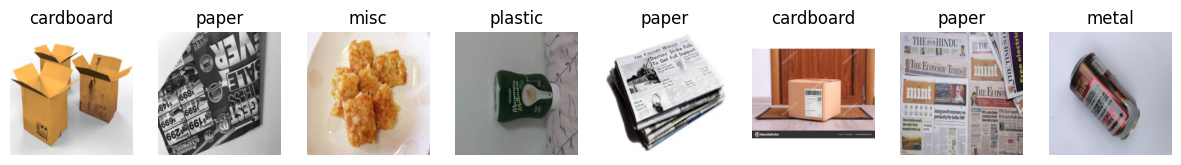

In [6]:
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]
plt.figure(figsize=(15,15))
for i in range(8):
  plt.subplot(8,8,i+1)
  img = np.transpose(images[i].numpy(), (1, 2, 0))  # Transpose the image dimensions
  plt.imshow(img)
  plt.title(label_str(labels[i].item()))
  plt.axis("off")

In [7]:
def train(model, num_epochs, lr, momentum):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)
    train_losses = []

    for i in range(num_epochs):
        loss_total = 0
        acc_train = 0
        total_train = 0

        # Progress bar for batches
        with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {i+1}", unit="batch") as batches:
            for ii, batch in batches:
                x = batch[0].to(device)
                y = batch[1].to(device)

                optimizer.zero_grad()
                loss, yhat = mart_loss(model, x, y, optimizer)

                loss_total += loss.item()
                loss.backward()
                optimizer.step()

                acc_train += torch.sum(torch.argmax(yhat, dim=1) == y)
                total_train += yhat.shape[0]

                # Update the batch progress bar description with the current loss and accuracy
                train_loss_avg = loss_total / (ii + 1)  # Ensure correct averaging
                train_acc_avg = acc_train.item() / total_train
                batches.set_postfix(loss=train_loss_avg, accuracy=train_acc_avg)

        train_losses.append(train_loss_avg)

        lr_scheduler.step()

        # Print information for this epoch
        print(f"Epoch {i+1}: Training Loss: {train_loss_avg:.4f}, Training Accuracy: {train_acc_avg:.4f}")

    print(f"Final Training Loss: {train_loss_avg:.4f}")
    print(f"Final Training Accuracy: {train_acc_avg:.4f}")

    # Plot the data
    plt.plot(train_losses, label='Training Loss')

    # Add legend, title, and labels
    plt.legend()
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Display the graph
    plt.show()

    return train_losses

In [10]:
model_classification = models.resnet50(pretrained=True)
model_classification.fc = nn.Linear(in_features=2048, out_features=6, bias=True)

# model_detection = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

In [11]:
torch.backends.cudnn.benchmark = True

train(model_classification, 5, 2e-3, 0.9)

Epoch 1:  20%|██        | 115/561 [02:06<08:09,  1.10s/batch, accuracy=0.391, loss=2.44]


KeyboardInterrupt: 

In [ ]:
def test(net):

  device = torch.device('cuda:0')
  net = net.to(device)
  net.eval()

  predictions = []
  true = []
  
  with torch.no_grad():

    total_loss = 0
    acc_test = 0
    total_test = 0
    
    for batch in test_loader:
      data = batch[0]
      label = batch[1]
      data, label = data.to(device), label.to(device)
      logits = net(data)
      if isinstance(logits, tuple):  # If the model returns a tuple
        logits = logits[0]
      else:  # If the model returns a single tensor
        logits = logits
      
      predictions.extend(torch.argmax(logits, dim=1).cpu().detach().numpy())
      true.extend(label.cpu().detach().numpy())
      
      loss = F.cross_entropy(logits, label)
      total_loss += loss.item()
      out = torch.argmax(logits, dim=1)
      acc_test += torch.sum(out == label)
      total_test += logits.shape[0]

  # Compute the confusion matrix for training data
  ax = plt.subplot()
  cm = confusion_matrix(true, predictions)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

  # Set labels, title, and tick parameters
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels([label_str(0), label_str(1), label_str(2), label_str(3), label_str(4), label_str(5)])
  ax.yaxis.set_ticklabels([label_str(0), label_str(1), label_str(2), label_str(3), label_str(4), label_str(5)], rotation=0, ha='right')

  # Rotate the tick labels for better readability
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

  # Display the plot
  plt.tight_layout()
  plt.show()
  print(f"Testing Loss: {total_loss/len(test_loader)}")
  print(f"Testing Accuracy: {acc_test/total_test}")

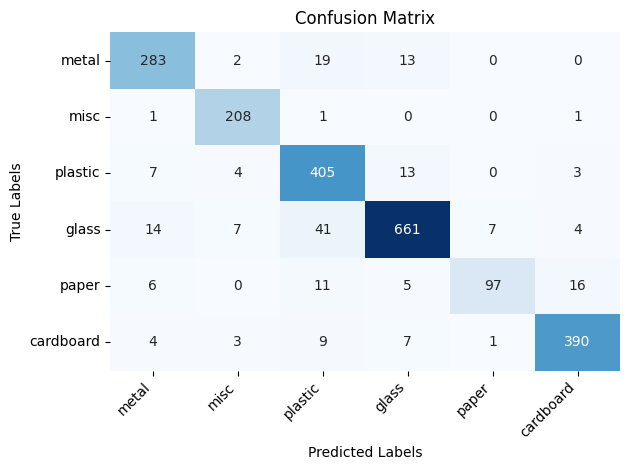

Testing Loss: 0.33223084534155434
Testing Accuracy: 0.911279559135437


In [ ]:
test(net)

In [ ]:
torch.save(model_classification, "../model/trash.pth")